# Gravitational orbits in Cartesian coordinates
---
#### In this notebook:
* Defines a GravitationalOrbits class to solve the two-body problem for gravitational attraction between two bodies in Cartesian coordinates.
* Shows that the problem reduces to the orbits we considered in class if one of the bodies is very heavy and you are in its rest frame.

First we import the modules we need.

In [6]:
%matplotlib inline
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

Then we define the **DoublePendulum** class.

In [1]:
class GravitationalOrbits():
    '''
    The GravitationalOrbits class contains the parameters and Lagrange's equations for 
    two bodies orbiting due to gravitational attraction.
    _____________
    Parameters:
    m1 -- float, mass of first body 
    m2 -- float, mass of second body
    G  -- float, gravitational constant
    _____________
    Methods: 
    dz_dt(t, z) -- Returns the right side of the differential equation at a given time, t, and z value.
    
    '''
    def __init__(self, m1=1., m2=1., G=1.):
        '''
        Initializes the class attributes. 
        '''
        self.m1 = m1
        self.m2 = m2
        self.G = G
        
    def dz_dt(self, t, z):
        '''
        Returns the right side of the differential equation:
        [dz/dt, d^2z/dt^2]
        ______________
        Parameters: 
        t -- float, time
        z -- float, vector where
             z[0] = x1, z[1] = x1_dot, z[2] = y1, z[3] = y1_dot
             z[4] = x2, z[5] = x2_dot, z[6] = y2, z[7] = y2_dot
        ______________
        Returns: 
        [z1, z1_dot, z2, z2_dot] where z1 and z2 are dphi_1/dt and dphi_2/dt (as above)
        '''
        r12 = np.sqrt( (z[4]-z[0])**2. + (z[6]-z[2])**2. )  # distance between bodies
        a1 = self.G * self.m2 / r12**3.                     
        a2 = -self.G * self.m1 / r12**3.
        x12 = z[4] - z[0]
        y12 = z[6] - z[2]
        
        return [z[1], a1*x12, z[3], a1*y12, z[5], a2*x12, z[7], a2*y12]
    
    def solve_ode(self, t_pts, z_0, abserr=1.0e-10, relerr=1.0e-10):
        '''
        Solves the ODE given initial conditions using solve_ivp.
        '''
        solution = solve_ivp(self.dz_dt, (t_pts[0], t_pts[-1]), 
                             z_0, t_eval=t_pts, method='RK23',
                             atol=abserr, rtol=relerr)
        x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = solution.z

        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot
    
    def leapfrog(self, t_pts, z_0):
        '''
        Solves the ODE given initial conditions using Leapfrog method.
        '''
        delta_t = t_pts[1] - t_pts[0]
        x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0 = z_0
    
        # Create arrays with zeros, same length as t_pts
        num = len(t_pts)
        x1 = np.zeros(num)
        y1 = np.zeros(num)
        x2 = np.zeros(num)
        y2 = np.zeros(num)
        x1_dot = np.zeros(num)
        y1_dot = np.zeros(num)
        x2_dot = np.zeros(num)
        y2_dot = np.zeros(num)
        x1_dot_half = np.zeros(num)
        y1_dot_half = np.zeros(num)
        x2_dot_half = np.zeros(num)
        y2_dot_half = np.zeros(num)
        
        # Set up initial conditions
        x1[0] = x1_0
        y1[0] = y1_0
        x2[0] = x2_0
        y2[0] = y2_0
        x1_dot[0] = x1_dot_0
        y1_dot[0] = y1_dot_0
        x2_dot[0] = x2_dot_0
        y2_dot[0] = y2_dot_0
        
        # Step through diff eq
        for i in np.arange(num - 1):
            t = t_pts[i]
            z = [x1[i], x1_dot[i], y1[i], y1_dot[i], x2[i], x2_dot[i], y2[i], y2_dot[i]]
           
            x1_dot_half[i] = x1_dot[i] + self.dz_dt(t,z)[1] * delta_t / 2.
            y1_dot_half[i] = y1_dot[i] + self.dz_dt(t,z)[3] * delta_t / 2.
            x2_dot_half[i] = x2_dot[i] + self.dz_dt(t,z)[5] * delta_t / 2.
            y2_dot_half[i] = y2_dot[i] + self.dz_dt(t,z)[7] * delta_t / 2.
            x1[i+1] = x1[i] + x1_dot_half[i] * delta_t
            y1[i+1] = y1[i] + y1_dot_half[i] * delta_t
            x2[i+1] = x2[i] + x2_dot_half[i] * delta_t
            y2[i+1] = y2[i] + y2_dot_half[i] * delta_t
            x1_dot[i+1] = x1_dot_half[i] + self.dz_dt(t,z)[1] * delta_t / 2.
            y1_dot[i+1] = y1_dot_half[i] + self.dz_dt(t,z)[3] * delta_t / 2.
            x2_dot[i+1] = x2_dot_half[i] + self.dz_dt(t,z)[5] * delta_t / 2.
            y2_dot[i+1] = y2_dot_half[i] + self.dz_dt(t,z)[7] * delta_t / 2.
            
        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot

Now we define a function for plotting.

In [8]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

And a function which returns stop and start indices for plotting. 

In [9]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

Getting ready to plot, we define labels for the axes, the plotting time, and the parameters, and instantiate a DoublePendulum object.

In [10]:
# Labels for individual plot axes
phi_vs_time_labels = (r'$t$', r'$\phi(t)$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

L1 = 1.
L2 = 1.
g = 1.
m1 = 1.
m2 = 1.

# Instantiate a double pendulum 
p1 = DoublePendulum(L1=L1, L2=L2, m1=m1, m2=m2, g=g)

Finally, define the initial conditions, solve given the initial conditions using **solve_ode()** (defined in the class), and plot $\phi_i(t)$ vs $t$.

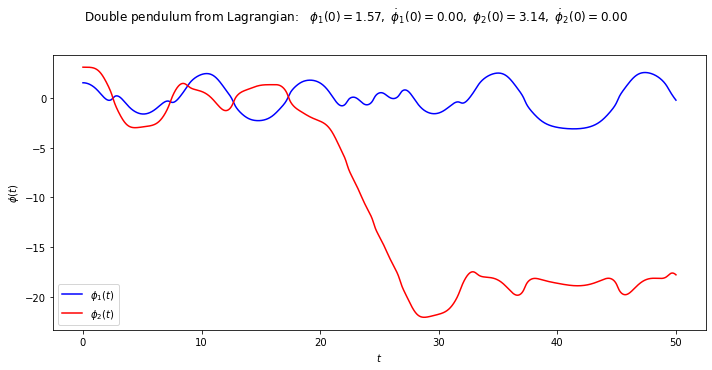

In [15]:
# Set initial conditions -- start at rest
phi_1_0 = np.pi/2.
phi_1_dot_0 = 0.
phi_2_0 = np.pi
phi_2_dot_0 = 0.

# Solve given the initial conditions
phi_1, phi_1_dot, phi_2, phi_2_dot = p1.solve_ode(t_pts, phi_1_0, phi_1_dot_0, phi_2_0, phi_2_dot_0)

# Start the plot!
# Set figure size and title
fig = plt.figure(figsize=(10,5)) 
overall_title = 'Double pendulum from Lagrangian:  ' + \
                rf' $\phi_1(0) = {phi_1_0:.2f},$' + \
                rf' $\dot\phi_1(0) = {phi_1_dot_0:.2f},$' + \
                rf' $\phi_2(0) = {phi_2_0:.2f},$' + \
                rf' $\dot\phi_2(0) = {phi_2_dot_0:.2f}$' 
fig.suptitle(overall_title, va='baseline')
    
ax_a = fig.add_subplot(1,1,1)                  

# Get start/stop indices and plot phi_i vs t using the plotting function 
start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi_1[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='blue',
            label=r'$\phi_1(t)$', 
            ax=ax_a)  
plot_y_vs_x(t_pts[start : stop], phi_2[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='red',
            label=r'$\phi_2(t)$',  
            ax=ax_a)  
fig.tight_layout()
fig.savefig('DoublePendulum.png', bbox_inches='tight')

Here we see the plot of $\phi(t)$ vs $t$ for both angles. The motion appears to be chaotic, but we can check that this system is sensitive to initial conditions by plotting $\Delta\phi(t)$ vs $t$. <br><br>

We will solve for two sets of initial conditions which are only slightly different. Here, we have only changed $\phi_1(0)$ by 0.00001. Then we plot the difference, $\Delta\phi(t)$, for both angles. 

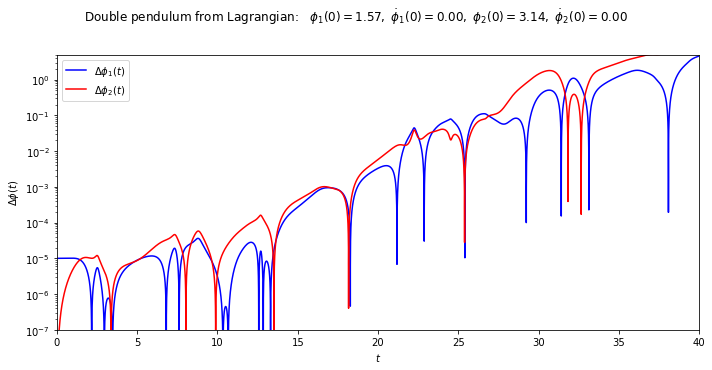

In [20]:
# Solve for two sets of slightly different initial conditions
phi_1, phi_1_dot, phi_2, phi_2_dot = p1.solve_ode(t_pts, phi_1_0, phi_1_dot_0, phi_2_0, phi_2_dot_0)
phi_1b, phi_1b_dot, phi_2b, phi_2b_dot = p1.solve_ode(t_pts, phi_1_0+0.00001, phi_1_dot_0, phi_2_0, phi_2_dot_0)

# Labels for individual plot axes
delta_phi_vs_time_labels = (r'$t$', r'$\Delta\phi(t)$')

# Start the plot!
fig = plt.figure(figsize=(10,5))
overall_title = 'Double pendulum from Lagrangian:  ' + \
                rf' $\phi_1(0) = {phi_1_0:.2f},$' + \
                rf' $\dot\phi_1(0) = {phi_1_dot_0:.2f},$' + \
                rf' $\phi_2(0) = {phi_2_0:.2f},$' + \
                rf' $\dot\phi_2(0) = {phi_2_dot_0:.2f}$' 
fig.suptitle(overall_title, va='baseline')
    
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], abs(phi_1[start : stop] - phi_1b[start : stop]), 
            axis_labels=delta_phi_vs_time_labels, 
            color='blue',
            semilogy=True, # make it a semilog plot
            label=r'$\Delta\phi_1(t)$',  
            ax=ax_a)  
plot_y_vs_x(t_pts[start : stop], abs(phi_2[start : stop] - phi_2b[start : stop]), 
            axis_labels=delta_phi_vs_time_labels, 
            color='red', 
            semilogy=True,
            label=r'$\Delta\phi_2(t)$', 
            ax=ax_a) 
ax_a.set_ylim(1.e-7, 5.)
ax_a.set_xlim(0., 40.)

fig.tight_layout()
fig.savefig('TestForChaos.png', bbox_inches='tight')

We can see here that the crests of $\Delta\phi_i(t)$ are increasing linearly on the semilog plot, meaning that $\Delta\phi_i(t)$ is actually increasing exponentially. This demonstrates an extreme sensitivity to initial conditions, which is a characteristic of **chaotic motion**.  